In [33]:
#Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import mahotas
import cv2
import os
import h5py
images_per_class       = 800
fixed_size             = tuple((500, 500))
train_path             = "dataset/train"
h5_train_data          = 'output/train_data.h5'
h5_train_labels        = 'output/train_labels.h5'
bins                   = 8


In [34]:
# Converting each image to RGB from BGR format
def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img


In [35]:
# Conversion to HSV image format from RGB

def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [36]:
# image segmentation

# for extraction of green and brown color


def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result


In [37]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [38]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [39]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

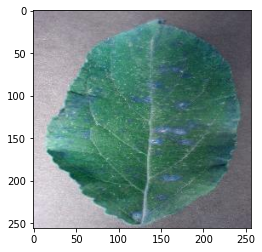

In [40]:
#Applying above image preproccessing(HOG) on sample image

image = cv2.imread(r'C:\Users\brainiac Abhinav\Plant-Disease-Detection\image.jpg')
plt.imshow(image)
plt.show()

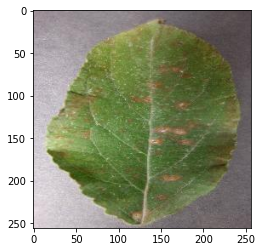

In [41]:
img=rgb_bgr(image)
plt.imshow(img)
plt.show()


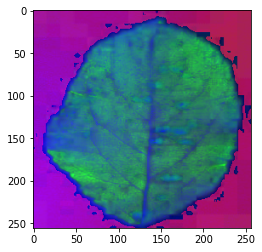

In [42]:
hsv_img=bgr_hsv(img)
plt.imshow(hsv_img)
plt.show()

In [43]:
#Applying image Secmentation
lower_green = np.array([25,0,20])
upper_green = np.array([100,255,255])
healthymask = cv2.inRange(hsv_img, lower_green, upper_green)
result = cv2.bitwise_and(img, img, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

NameError: name 'mask' is not defined

In [ ]:
#Applying image segmentation
lower_brown = np.array([10,0,10])
upper_brown = np.array([30,255,255])
disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
disease_result = cv2.bitwise_and(img, img, mask=disease_mask)
plt.subplot(1, 2, 1)
plt.imshow(disease_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(disease_result)
plt.show()

In [ ]:
final_result=img_segmentation(img,hsv_img)
final_mask = healthy_mask + disease_mask
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()

In [ ]:
#Hu moments Feature value for Segmented Image
hu_moments=fd_hu_moments(final_result)
hu_moments

In [ ]:
#Haralick texture extraction of Segmented Image
haralick=fd_haralick(final_result)
haralick

In [ ]:
#Color Histogram feature Extraction of segmented Image
histogram=fd_histogram(final_result)
histogram


In [ ]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

In [ ]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".jpg"

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        
        # Running Function Bit By Bit
        
        RGB_BGR       = rgb_bgr(image)
        BGR_HSV       = bgr_hsv(RGB_BGR)
        IMG_SEGMENT   = img_segmentation(RGB_BGR,BGR_HSV)

        # Call for Global Fetaure Descriptors
        
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        
        # Concatenate 
        
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

In [ ]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

In [ ]:
# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

In [ ]:
# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

In [ ]:
# scale features in the range (0-1)
from sklearn.preprocessing import MinMaxScaler
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

In [ ]:
print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

In [ ]:
# save the feature vector using HDF5
h5f_data = h5py.File(h5_train_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

In [ ]:
h5f_label = h5py.File(h5_train_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

In [ ]:
h5f_data.close()
h5f_label.close()

In [ ]:
# training
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib

warnings.filterwarnings('ignore')

num_trees = 100
test_size = 0.20
seed      = 9
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_train_data, 'r')
h5f_label = h5py.File(h5_train_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")


In [ ]:
# split the training and testing data
(trainFeature, testFeature, trainLabelsFeature, testLabelsFeature) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainFeature.shape))
print("Test data   : {}".format(testFeature.shape)) 

In [ ]:
trainFeature

In [ ]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed,shuffle=True)
    cv_results = cross_val_score(model, trainFeature, trainLabelsFeature, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

In [ ]:
clf.fit(trainFeature, trainLabelsFeature)


In [ ]:
y_predict=clf.predict(testFeature)

In [ ]:
y_predict

In [ ]:
cm = confusion_matrix(testLabelsFeature,y_predict)

In [ ]:
import seaborn as sns
sns.heatmap(cm ,annot=True)

In [ ]:
print(classification_report(testLabelsFeatures,y_predict))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(testLabelsFeatures, y_predict)